In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy.stats import kruskal
from scipy.stats import gaussian_kde

from statsmodels.stats.multitest import multipletests

import cancer_data 
import many

from adjustText import adjust_text

import config
config.config_visuals()

# Load data

In [2]:
merged_ccle_info = pd.read_csv(
    "../data/supplementary/S1_merged-ccle-info.txt", sep="\t", index_col=0
)
merged_tcga_info = pd.read_csv(
    "../data/supplementary/S2_merged-tcga-info.txt", sep="\t", index_col=0
)

In [10]:
merged_tcga_info[merged_tcga_info["MSI"]==True]["Abbreviated_disease"].value_counts()

UCEC    170
COAD     85
STAD     84
BRCA     16
DLBC     11
CESC      8
READ      7
OV        7
KIRC      5
HNSC      4
ACC       4
PRAD      3
LUSC      3
LUAD      3
LIHC      3
SKCM      3
ESCA      3
UCS       2
BLCA      2
SARC      2
MESO      2
LGG       2
GBM       1
THYM      1
Name: Abbreviated_disease, dtype: int64

# MSI occurrence

In [11]:
tcga_msi_types = ["COAD", "STAD", "UCEC"]
ccle_msi_types = [
    "Colon/Colorectal Cancer",
    "Endometrial/Uterine Cancer",
    "Ovarian Cancer",
    "Gastric Cancer",
]

merged_ccle_info["RPL22_k15"] = (
    merged_ccle_info["RPL22_mutation"]
    .dropna()
    .apply(lambda x: "chr1_6257785-6257785_T>-" in x)
)

tcga_msi_type_filtered = merged_tcga_info[
    merged_tcga_info["Abbreviated_disease"].isin(tcga_msi_types)
]
ccle_msi_type_filtered = merged_ccle_info[
    merged_ccle_info["Primary_disease"].isin(ccle_msi_types)
]

tcga_msi_type_filtered = tcga_msi_type_filtered.dropna(
    subset=["MSI", "RPL22_k15fs_mutation"], axis=0
)
ccle_msi_type_filtered = ccle_msi_type_filtered.dropna(
    subset=["MSI", "RPL22_k15"], axis=0
)

tcga_msi_type_filtered = tcga_msi_type_filtered[tcga_msi_type_filtered["MSI"]==True]
ccle_msi_type_filtered = ccle_msi_type_filtered[ccle_msi_type_filtered["MSI"]==True]

ccle_msi_type_filtered["Primary_disease"] = ccle_msi_type_filtered[
    "Primary_disease"
].replace(
    {
        "Colon/Colorectal Cancer": "Colon",
        "Endometrial/Uterine Cancer": "Endometrial",
        "Ovarian Cancer": "Ovarian",
        "Gastric Cancer": "Gastric",
    }
)

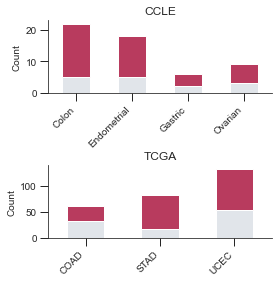

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(4, 4))

ax = axes[0]

ccle_msi_type_filtered.groupby(["Primary_disease", "RPL22_k15"]).size().unstack(
    -1
).plot(
    kind="bar",
    stacked=True,
    ax=ax,
    legend=False,
    cmap=mpl.colors.ListedColormap(["#e1e5ea", "#b83b5e"]),
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("")
ax.set_ylabel("Count")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment="right",
)
ax.set_title("CCLE")

ax = axes[1]

tcga_msi_type_filtered.groupby(
    ["Abbreviated_disease", "RPL22_k15fs_mutation"]
).size().unstack(-1).plot(
    kind="bar",
    stacked=True,
    ax=ax,
    legend=False,
    cmap=mpl.colors.ListedColormap(["#e1e5ea", "#b83b5e"]),
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel("")
ax.set_ylabel("Count")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment="right",
)
ax.set_title("TCGA")

plt.subplots_adjust(hspace=1)

plt.savefig("../plots/1_msi-totals.pdf", transparent=True, bbox_inches="tight")

# Boxplots

In [3]:
def tcga_rpl22_status(row):
    if row["RPL22_k15fs_mutation"] == True:
        return "K15.fs"

    else:
        if not np.isnan(row["RPL22_copy_number_thresholded"]):
            return "ΔCN=" + str(int(row["RPL22_copy_number_thresholded"]))
        
        return np.nan


merged_tcga_info["RPL22_status"] = merged_tcga_info.apply(tcga_rpl22_status, axis=1)

rpl22_order = ["K15.fs", "ΔCN=-2", "ΔCN=-1", "ΔCN=0", "ΔCN=1", "ΔCN=2"]

mut_hue = "#e23e57"
wt_hue = "#eaeaea"

rpl22_hues = dict(zip(rpl22_order, [mut_hue] + [wt_hue] * 5))

In [4]:
def plot_rpl22(rpl22_info, y, ylabel="y"):

    plt.figure(figsize=(4, 3))

    ax = plt.subplot(111)

    rpl22_info_join = rpl22_info.join(y.dropna(), how="inner")

    rpl22_counts = rpl22_info_join["RPL22_status"].value_counts()

    grouped_y = rpl22_info_join.groupby("RPL22_status")[y.name].apply(list)
    grouped_y = list(grouped_y)

    pval = kruskal(*grouped_y)[1]

    flierprops = dict(
        marker=".",
        markersize=8,
        markerfacecolor=(0, 0, 0, 0),
        markeredgecolor="black",
        markeredgewidth=0.5,
    )

    sns.boxplot(
        rpl22_info["RPL22_status"],
        y,
        notch=True,
        order=rpl22_order,
        bootstrap=1000,
        palette=rpl22_hues,
        flierprops=flierprops,
    )

    plt.xlabel("RPL22 status")
    plt.ylabel(ylabel)

    if pval == 0:
        plt.text(
            0.05, 1.025, "P < " + many.visuals.as_si(10 ** (-320), 2), transform=ax.transAxes
        )

    else:
        plt.text(0.05, 1.025, "P = " + many.visuals.as_si(pval, 2), transform=ax.transAxes)

    xticks = [x + "\n (" + str(int(rpl22_counts.loc[x])) + ")" for x in rpl22_order]

    ax.set_xticklabels(xticks)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.spines["left"].set_position(("axes", -0.025))
    ax.spines["bottom"].set_position(("axes", -0.025))

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


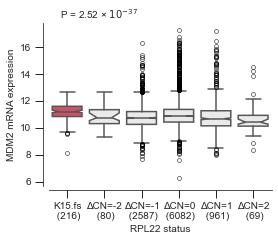

In [5]:
plot_rpl22(merged_tcga_info[["RPL22_status"]], merged_tcga_info["MDM2_mRNA"], "MDM2 mRNA expression")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


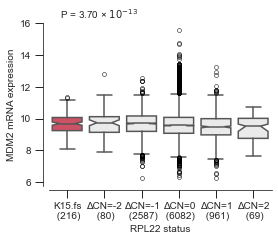

In [6]:
plot_rpl22(merged_tcga_info[["RPL22_status"]], merged_tcga_info["MDM4_mRNA"], "MDM2 mRNA expression")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


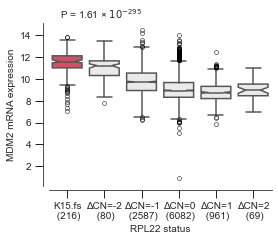

In [7]:
plot_rpl22(merged_tcga_info[["RPL22_status"]], merged_tcga_info["RPL22L1_mRNA"], "MDM2 mRNA expression")

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


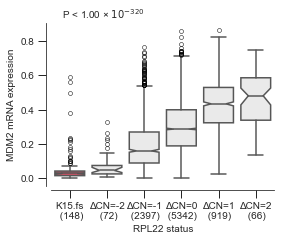

In [8]:
plot_rpl22(merged_tcga_info[["RPL22_status"]], merged_tcga_info["RPL22L1_exon_3A_inclusion"], "MDM2 mRNA expression")

plt.savefig(
    "../plots/rpl22l1-exon-3a_rpl22_tcga.pdf", bbox_inches="tight", transparent=True
)

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


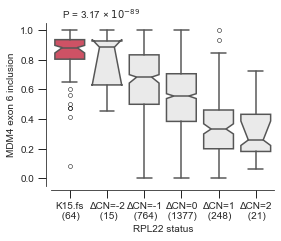

In [16]:
plot_rpl22(merged_tcga_info[["RPL22_status"]], merged_tcga_info["MDM4_exon_6_inclusion"], "MDM4 exon 6 inclusion")

plt.savefig(
    "../plots/1e_rpl22l1-exon-3a_rpl22-tcga.pdf", bbox_inches="tight", transparent=True
)

# TCGA correlations

In [10]:
tcga_mdm4_cosplicing = pd.read_csv(
    "../data/supplementary/S4-a_tcga-mdm4-cosplicing.txt", sep="\t", index_col=0
)
tcga_rpl22l1_cosplicing = pd.read_csv(
    "../data/supplementary/S4-b_tcga-rpl22l1-cosplicing.txt", sep="\t", index_col=0
)

tcga_mdm4_cosplicing = tcga_mdm4_cosplicing[np.abs(tcga_mdm4_cosplicing["spearman"]) < 0.99]
tcga_rpl22l1_cosplicing = tcga_rpl22l1_cosplicing[np.abs(tcga_rpl22l1_cosplicing["spearman"]) < 0.99]

/Users/kevinhu/Library/Caches/pypoetry/virtualenvs/kevinhu-Rgu4vvcg-py3.9/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [11]:
g19_7_definitions = cancer_data.load("g19_7_definitions")
ensg_id_to_name = dict(zip(g19_7_definitions["gene_id"],g19_7_definitions["gene_name"]))

tcga_mdm4_cosplicing["label"] = tcga_mdm4_cosplicing["first_splicing_event"].apply(
    lambda x: f"{ensg_id_to_name.get(x.split('_')[0],'unnamed')}_{x.split('_')[1]}_{x.split('_')[2]}_{x.split('_')[-1]}"
)
tcga_rpl22l1_cosplicing["label"] = tcga_rpl22l1_cosplicing["first_splicing_event"].apply(
    lambda x: f"{ensg_id_to_name.get(x.split('_')[0],'unnamed')}_{x.split('_')[1]}_{x.split('_')[2]}_{x.split('_')[-1]}"
)

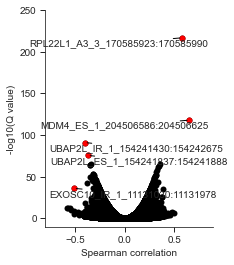

In [15]:
plt.figure(figsize=(3, 4))

labels_mask = tcga_mdm4_cosplicing["-log10(Q value)"] > 100

labels_mask = labels_mask | (
    (tcga_mdm4_cosplicing["spearman"] < 0)
    & (tcga_mdm4_cosplicing["-log10(Q value)"] > 65)
)
labels_mask = labels_mask | (
    (tcga_mdm4_cosplicing["-log10(Q value)"] > 25)
    & (tcga_mdm4_cosplicing["spearman"] < -0.5)
)

many.visuals.dense_plot(
    tcga_mdm4_cosplicing["spearman"],
    tcga_mdm4_cosplicing["-log10(Q value)"],
    text_adjust=True,
    labels_mask=labels_mask,
    labels=tcga_mdm4_cosplicing["label"],
    colormap=None,
)

plt.xlabel("Spearman correlation")
plt.ylabel("-log10(Q value)")

plt.savefig(
    "../plots/1c_mdm4-cosplicing.pdf", dpi=512, bbox_inches="tight", transparent=True
)

Text(-2.125, 0.5, '-log10(Q value)')

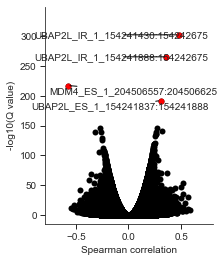

In [13]:
plt.figure(figsize=(3, 4))

labels_mask = tcga_rpl22l1_cosplicing["-log10(Q value)"] > 150

many.visuals.dense_plot(
    tcga_rpl22l1_cosplicing["spearman"],
    tcga_rpl22l1_cosplicing["-log10(Q value)"],
    text_adjust=True,
    labels_mask=labels_mask,
    labels=tcga_rpl22l1_cosplicing["label"],
    colormap=None,
)

plt.xlabel("Spearman correlation")
plt.ylabel("-log10(Q value)")

# RPL22 alterations by primary site

In [14]:
rpl22_subtype_info = rpl22_info.join(
    tcga_sample_info["abbreviated_disease"], how="inner"
)

subtype_proportions = rpl22_subtype_info.groupby(["abbreviated_disease"])[
    "RPL22_status"
].value_counts()
subtype_proportions = subtype_proportions.unstack().fillna(0)

subtype_totals = subtype_proportions.sum(axis=1)

subtype_proportions = subtype_proportions.div(subtype_totals, axis=0) * 100
subtype_proportions["total"] = subtype_totals.astype(int)

altered_classes = [
    "ΔCN=-1",
    "ΔCN=-2",
    "K15.fs",
]

subtype_proportions["altered_proportion"] = subtype_proportions[altered_classes].sum(
    axis=1
)
subtype_proportions = subtype_proportions.sort_values(
    by="altered_proportion", ascending=False
)

subtype_proportions["display_disease"] = subtype_proportions.index
subtype_proportions["display_disease"] = (
    subtype_proportions["display_disease"]
    + " ("
    + subtype_proportions["total"].astype(str)
    + ")"
)

subtype_proportions = subtype_proportions[subtype_proportions["total"] >= 50]

NameError: name 'rpl22_info' is not defined

In [ ]:
plt.figure(figsize=(7, 3))

ax = plt.subplot(111)

subtype_proportions.plot(
    x="display_disease",
    y=altered_classes,
    kind="bar",
    stacked=True,
    cmap=mpl.colors.ListedColormap(["#ebd5d5", "#fab57a", "#b83b5e"]),
    ax=ax,
    width=0.75,
)

plt.xlabel("Subtype disease")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_position(("axes", -0.025))

plt.xticks(rotation=45, ha="right")

plt.ylabel("% affected")

plt.savefig(
    "../plots/rpl22_subtype_distribution.pdf", bbox_inches="tight", transparent=True
)

# CCLE

## RPPA correlations

In [ ]:
mdm4_rppa = pd.concat(
    [
        merged_ccle_info["MDM4_ENSG00000198625.8_mRNA"].rename("MDM4_genex"),
        merged_ccle_info["MDM4_mean_chr1_204506558_204506625_ENSG00000198625.8_exonusage"].rename("MDM4_exon_6"),
        merged_ccle_info["MDM4_RPPA_protein"].rename("MDM4_protein"),
    ],
    axis=1,
    sort=True,
)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(7, 7 / 3), sharey=True)

text_pos = (0.075, 0.925)

ax = axes[0]
many.visuals.dense_regression(
    mdm4_rppa["MDM4_genex"],
    mdm4_rppa["MDM4_protein"],
    "pearson",
    ax=ax,
    text_pos=text_pos,
    colormap="Blues",
    cmap_offset=0.5,
)
ax.set_ylabel("MDM4 protein (RPPA)")
ax.set_xlabel("MDM4 mRNA")

ax = axes[1]
many.visuals.dense_regression(
    mdm4_rppa["MDM4_exon_6"],
    mdm4_rppa["MDM4_protein"],
    "pearson",
    ax=ax,
    text_pos=text_pos,
    colormap="Blues",
    cmap_offset=0.5,
)
ax.set_xlabel("MDM4 exon 6 inclusion")

mult = np.log2(2 ** mdm4_rppa["MDM4_genex"] * mdm4_rppa["MDM4_exon_6"] + 1)

ax = axes[2]
many.visuals.dense_regression(
    mult,
    mdm4_rppa["MDM4_protein"],
    "pearson",
    ax=ax,
    text_pos=text_pos,
    colormap="Blues",
    cmap_offset=0.5,
)

ax.set_xlabel("MDM4 mRNA × exon 6")

plt.savefig(
    "../plots/MDM4_RPPA_correlations.pdf",
    bbox_inches="tight",
    transparent=True,
    dpi=512,
)

## Mass-spec correlations

In [ ]:
mdm4_ms = pd.concat(
    [
        merged_ccle_info["MDM4_ENSG00000198625.8_mRNA"].rename("MDM4_genex"),
        merged_ccle_info["MDM4_mean_chr1_204506558_204506625_ENSG00000198625.8_exonusage"].rename("MDM4_exon_6"),
        merged_ccle_info["MDM4_MS_protein"].rename("MDM4_protein"),
    ],
    axis=1,
    sort=True,
)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(7, 7 / 3), sharey=True)

text_pos = (0.075, 0.925)

ax = axes[0]
many.visuals.dense_regression(
    mdm4_ms["MDM4_genex"],
    mdm4_ms["MDM4_protein"],
    "pearson",
    ax=ax,
    text_pos=text_pos,
    colormap="Blues",
    cmap_offset=0.5,
)
ax.set_ylabel("MDM4 protein (MS)")
ax.set_xlabel("MDM4 mRNA")

ax = axes[1]
many.visuals.dense_regression(
    mdm4_ms["MDM4_exon_6"],
    mdm4_ms["MDM4_protein"],
    "pearson",
    ax=ax,
    text_pos=text_pos,
    colormap="Blues",
    cmap_offset=0.5,
)
ax.set_xlabel("MDM4 exon 6 inclusion")

mult = np.log2(2 ** mdm4_rppa["MDM4_genex"] * mdm4_rppa["MDM4_exon_6"] + 1)

ax = axes[2]
many.visuals.dense_regression(
    mult,
    mdm4_ms["MDM4_protein"],
    "pearson",
    ax=ax,
    text_pos=text_pos,
    colormap="Blues",
    cmap_offset=0.5,
)

ax.set_xlabel("MDM4 mRNA × exon 6")

plt.savefig(
    "../plots/MDM4_MS_correlations.pdf",
    bbox_inches="tight",
    transparent=True,
    dpi=512,
)